<a href="https://colab.research.google.com/github/sadjadasghari/Colab/blob/main/model_assisted_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labelbox model assisted labeling

This tutorial implements Labelbox model assisted labeling (MAL) system (https://labelbox.com/docs/automation/model-assisted-labeling) for object detection (bbox) and image segmentation (masks) with Facebook Detectron2 framework. MAL integrates Labelbox labeling workflow directly with the user AI model. MAL is a superior technique to quickly improve AI model performance. 

#### ![MAL](https://files.helpdocs.io/3fu9z5w5lj/articles/6o94494p7f/1587521917175/model-assisted-labeli.png)

### What you need and know before getting started?
- Labelbox API key
- A partially labeled project in Labelbox. (bounding box or segmentation)
- (optional) GCS credentials to upload segmentation masks to a bucket.
- For ideal performance, replace Facebook Detectron2 with your own AI model.
---

### Workflow
**Data preparation (egress)**
- Generate Labelbox project export and download labels (Labelbox)
- Access ontology (Labelbox)
- Convert labels into Facebook Detectron2 custom format (Labelbox)

**Train your AI model**
- Visualize Detectron2 training data (Labelbox)
- Configure Detectron2 Training configuration (Labelbox)
- Run Detectron2 training (Labelbox)
- Evaluate Detectron2 performance (Labelbox)

**Data preparation (inference)**
- Compute unlabeled datarows within a project for inferencing (Labelbox)

**Model inferencing on unlabeled data**
- Run Detectron2 inference on queued datarows (Detectron)

**Data preparation (ingress)**
- Convert Detectron2 inference results to Labelbox annotation import format (Labelbox)
- Initiate bulk import request to import pre-labels (Labelbox)


---

# About
[Labelbox](https://labelbox.com/) is a training data platform to easily create training data and improve model performance. 

#### ![Labelbox workmark](https://i.imgur.com/ufIZpXq.png)

# Install dependencies 

In [ ]:
# !pip3 install --upgrade pip setuptools
!pip3 install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip3 install cython pyyaml==5.1
!pip3 install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
!pip3 install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
# !pip3 install opencv-python
!pip3 install labelbox
!pip3 install simplejson
!pip3 install progressbar
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip3 install google-cloud-storage

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-4roin59p
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-4roin59p
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266457 sha256=273dc5fef140776ebb4af38e7ab39b64a55d5b7fc6ee4b5042d9f779ee2c96d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-qzv_t38n/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.

# Import libraries

In [ ]:

##General utilities
import datetime as dt
import os
import sys
import random
import time
from itertools import cycle
from uuid import uuid4
import requests
from pprint import pprint
from multiprocessing.pool import ThreadPool
import os, os.path
import numpy as np
import cv2
from skimage import io
import simplejson as json
import random
from datetime import datetime
import time
import shutil
from matplotlib import pyplot as plt
from pycocotools import mask
import progressbar
from PIL import Image
from google.cloud import storage
from google.colab.patches import cv2_imshow

##Labelbox utilities
import labelbox as lb
from labelbox import Project, Dataset
from labelbox.schema.bulk_import_request import BulkImportRequest
from labelbox.schema.enums import BulkImportRequestState

##Facebook Detectron2 utilities
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# Configure parameters

In [ ]:
##Constants and configuration
LB_API_KEY = "ENTER_YOUR_API_KEY"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "gcs.json" # Needed to upload segmentation masks. Create GCS service account key (https://cloud.google.com/iam/docs/creating-managing-service-account-keys)

### Uncomment the object detection example to use with object detection projects

# # Object detection example
# PROJECT_ID='ckc787iv0gs560815d3u40kez' #labelbox project id
# DATASETS=['ckc24bd45nng409881q99fbvw'] #labelbox dataset ids attached to the project
# MODE = 'object-detection'


#Segmentation example 
PROJECT_ID='ck7wos1ri5o9f0a00jb1oyqgc' #labelbox project id
DATASETS=['cjz9rwfontpz50763bx4n1bmd'] #labelbox dataset ids attached to the project
DATA_LOCATION = 'seg-data/'
MODE = 'segmentation-rle'

## Universal configuration
DOWNLOAD_IMAGES = True # Download data from labelbox. Set false for re-runs when data already exists locally
VALIDATION_RATIO = 0.1 # Validation data / training data ratio
NUM_CPU_THREADS = 8 # for multiprocess downloads
NUM_SAMPLE_LABELS = 0 # Use 0 to use all of the labeled training data from project. Otherwise specify number of labeled images to use. Use smaller number for faster iteration. 
PRELABELING_THRESHOLD = 0.6 # minimum model inference confidence threshold to be uploaded to labelbox
HEADLESS_MODE = False # Set True to skip previewing data or model results

DETECTRON_DATASET_TRAINING_NAME = 'prelabeling-train'
DETECTRON_DATASET_VALIDATION_NAME = 'prelabeling-val'

# Functions

In [ ]:
## get project ontology from labelbox
def get_ontology(project_id):
    response = client.execute(
                """
                query getOntology (
                    $project_id : ID!){ 
                    project (where: { id: $project_id }) { 
                        ontology { 
                            normalized 
                        } 
                    }
                }
                """,
                {"project_id": project_id})
            
    ontology = response['project']['ontology']['normalized']['tools']

    ##Return list of tools and embed category id to be used to map classname during training and inference
    mapped_ontology = []
    thing_classes = []
    
    i=0
    for item in ontology:
#         if item['tool']=='superpixel' or item['tool']=='rectangle':
        item.update({'category': i})
        mapped_ontology.append(item)
        thing_classes.append(item['name'])
        i=i+1         

    return mapped_ontology, thing_classes

## Creates a new export request to get all labels from labelbox. 
def get_labels(project_id):
    should_poll = 1
    while(should_poll == 1):
        response = client.execute(
                    """
                    mutation export(
                    $project_id : ID!    
                    )
                    { 
                        exportLabels(data:{ projectId: $project_id }){ 
                            downloadUrl 
                            createdAt 
                            shouldPoll 
                        }
                    }
                    """,
                    {"project_id": project_id})
        
        if response['exportLabels']['shouldPoll'] == False:
            should_poll = 0
            url = response['exportLabels']['downloadUrl']
            headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36"}

            r = requests.get(url, headers=headers)
            
            print('Export generated')
            ## writing export to disc for easier debugging
            open('export.json', 'wb').write(r.content)
            return r.content
        else:
            print('Waiting for export generation. Will check back in 10 seconds.')    
            time.sleep(10)

    return response

## Get all previous predictions import (bulk import request). 
def get_current_import_requests():
    response = client.execute(
                    """
                    query get_all_import_requests(
                        $project_id : ID! 
                    ) {
                      bulkImportRequests(where: {projectId: $project_id}) {
                        id
                        name
                      }
                    }
                    """,
                    {"project_id": PROJECT_ID})
    
    return response['bulkImportRequests']

## Delete all current predictions in a project and dataset. We want to delete them and start fresh with predictions from the latest model iteration
def delete_import_request(import_request_id):
    response = client.execute(
                    """
                        mutation delete_import_request(
                            $import_request_id : ID! 
                        ){
                          deleteBulkImportRequest(where: {id: $import_request_id}) {
                            id
                            name
                          }
                        }
                    """,
                    {"import_request_id": import_request_id})
    
    return response

## function to return the difference between two lists. This is used to compute the queued datarows to be used for inference. 
def diff_lists(li1, li2): 
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2] 
    return li_dif 

## Generic data download function
def download_files(filemap):
    path, uri = filemap    
    ## Download data
    if not os.path.exists(path):
        r = requests.get(uri, stream=True)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
    return path

## Converts binary image mask into COCO RLE format
def rle_encode(mask_image):
    size = list(mask_image.shape)
    pixels = mask_image.flatten()
    
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    
    rle = {'counts': runs.tolist(), 'size': size}
    return rle


def load_set(dir):
    with open(dir+"dataset.json") as json_file:
        dataset_dicts = json.loads(json_file)
    return dataset_dicts

def cv2_imshow(a, **kwargs):
#     a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

def upload_to_gcs(file_name):
    bucket = storage_client.get_bucket("predictions-import-test")
    blob = bucket.blob("{}.png".format(str(uuid4())))
    blob.upload_from_filename(file_name)
    return blob.generate_signed_url(dt.timedelta(weeks=10))

def mask_to_cloud(img, mask_array, filename):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    im = Image.fromarray(output)
    im.save(DATA_LOCATION+'tmp/'+filename+'.png')
    
    cloud_mask = upload_to_gcs(DATA_LOCATION+'tmp/'+filename+'.png')
#     plt.imshow(im)
    return cloud_mask

## Convert and load labelbox labels into Detectron2 format
def load_detectron2_dataset(labels, ontology, thing_classes, dir):
    dataset_dicts = []
    i = 0
    total = len(labels)

    print("Num labels processing: " + str(total))
    time.sleep(1)
    bar = progressbar.ProgressBar(maxval=total, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    for label in labels:
        
        try:
            record = {}
            filename = os.path.join(dir, label['External ID'])
            
            ##scikit needed to raise exception if unable to read the image
            _ = io.imread(filename)
            
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["height"] = height
            record["width"] = width
            record["image_id"] = label['ID']

            objs = []

            for instance in label['Label']['objects']:
                category_id = thing_classes.index(instance['title'])
#                 print(category_id)
                if MODE == 'object-detection':
                    obj = {
                            "bbox": [instance['bbox']['left'], instance['bbox']['top'], instance['bbox']['width'], instance['bbox']['height']],
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": [],
                            "category_id": category_id,
                        }
                    objs.append(obj)

                if MODE == 'segmentation-rle':
                    path = DATA_LOCATION+masks+'/'+label['External ID']
                    mask_URI = instance['instanceURI']
                    downloaded_path = download_files((path, mask_URI))
                    im = cv2.imread(downloaded_path,0)

                    binary = np.array(im)

                    rle = mask.encode(np.asfortranarray(binary))
                    ground_truth_bounding_box = mask.toBbox(rle)

                    obj = {
                            "bbox": ground_truth_bounding_box.tolist(),
                            "bbox_mode": BoxMode.XYWH_ABS,
                            "segmentation": rle,
                            "category_id": category_id,
                            "iscrowd": 0
                        }
                    objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)
            
            bar.update(i+1)
            i=i+1
        except Exception as e:
            print('Exception: ', e)

    bar.finish()
            
    ## Write detectron2 dataset file to disk for easier debugging
    f = open(dir+"dataset_dict.json","w")
    f.write(json.dumps(dataset_dicts))
    f.close()
    
    return dataset_dicts

class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"

        return COCOEvaluator(dataset_name, cfg, False, output_folder)

# Main

Available classes:  ['Lesion']
Export generated

Finished downloading training and validation data... 

Num labels processing: 2297


Exception:  'NoneType' object is not subscriptable


Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'


Num labels processing: 255


Exception:  'objects'


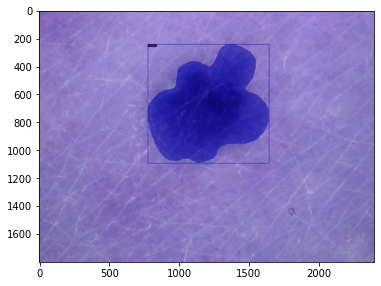

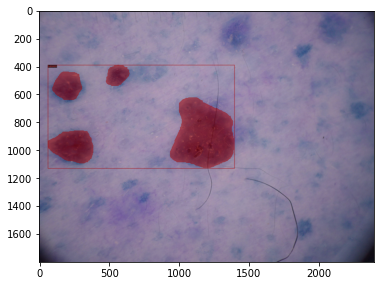

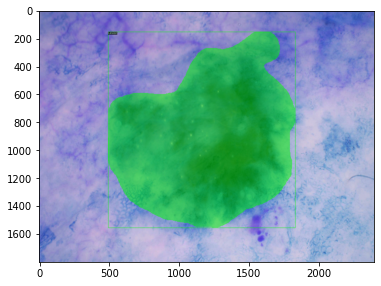

In [ ]:
start_time = time.time()

if os.path.exists('coco_eval'):
    shutil.rmtree('coco_eval')
    
client = lb.Client(LB_API_KEY, "https://api.labelbox.com/graphql")
storage_client = storage.Client()

## Get labelbox project
project = client.get_project(PROJECT_ID)

##Get ontology
ontology, thing_classes = get_ontology(PROJECT_ID)
print('Available classes: ', thing_classes)

##Get labels
labels = json.loads(get_labels(PROJECT_ID))

##Split training and validation labels
if NUM_SAMPLE_LABELS !=0:
    val_sample = int(VALIDATION_RATIO*NUM_SAMPLE_LABELS)
    val_labels = random.sample(labels, val_sample)
    train_labels = random.sample(labels, NUM_SAMPLE_LABELS)
else:
    split = int(VALIDATION_RATIO*len(labels))
    val_labels = labels[:split]
    train_labels = labels[split:]

## Check and create folders for downloading data from Labelbox
train = 'train'
val = 'val'
inference = 'inference'
masks = 'masks'
tmp = 'tmp'

if not os.path.exists(DATA_LOCATION):
    os.makedirs(DATA_LOCATION)

if not os.path.exists(DATA_LOCATION+train):
    os.makedirs(DATA_LOCATION+train)
    
if not os.path.exists(DATA_LOCATION+val):
    os.makedirs(DATA_LOCATION+val)
    
if not os.path.exists(DATA_LOCATION+inference):
    os.makedirs(DATA_LOCATION+inference)
    
if not os.path.exists(DATA_LOCATION+masks):
    os.makedirs(DATA_LOCATION+masks)
    
if not os.path.exists(DATA_LOCATION+tmp):
    os.makedirs(DATA_LOCATION+tmp)
    
##Download training and validation labels in parallel
train_urls = []
for label in train_labels:
    train_urls.append((DATA_LOCATION+'train/' + label['External ID'], label['Labeled Data']))

val_urls = []
for label in val_labels:
    val_urls.append((DATA_LOCATION+'val/' + label['External ID'], label['Labeled Data']))


if(DOWNLOAD_IMAGES==True):
    print('Downloading training and validation data... \n')
    
    results_train = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, train_urls)
    results_val = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, val_urls)
    
    for item in results_train:
        pass
    for item in results_val:
        pass
    
    print('Finished downloading training and validation data... \n')
    

### Begin FB Detectron code. 

#Load dataset into Detectron2
try:
    DatasetCatalog.register(DETECTRON_DATASET_TRAINING_NAME, lambda: load_detectron2_dataset(train_labels, ontology, thing_classes, DATA_LOCATION+'train/' ))
    DatasetCatalog.register(DETECTRON_DATASET_VALIDATION_NAME, lambda: load_detectron2_dataset(val_labels, ontology, thing_classes, DATA_LOCATION+'val/' ))
    MetadataCatalog.get(DETECTRON_DATASET_TRAINING_NAME).thing_classes=thing_classes
    MetadataCatalog.get(DETECTRON_DATASET_VALIDATION_NAME).thing_classes=thing_classes
except Exception as e:
    print(e)
    
if MODE == 'object-detection':
    model = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
    
if MODE == 'segmentation-rle':
    model = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'


##Load data and metadata for visualization and inference
dataset_dicts = DatasetCatalog.get(DETECTRON_DATASET_TRAINING_NAME)
dataset_dicts_val = DatasetCatalog.get(DETECTRON_DATASET_VALIDATION_NAME)
metadata = MetadataCatalog.get(DETECTRON_DATASET_TRAINING_NAME)

##check if the training data is loaded correctly
if HEADLESS_MODE==False:
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=4)
        vis = visualizer.draw_dataset_dict(d)
        
        ## For paperspace cloud notebooks. Cloud notebooks do not support cv2.imshow.
        plt.rcParams['figure.figsize'] = (6, 12)
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.show()

# Train Detectron2 Model

In [ ]:
## Train the model. Change the parameters as per your needs. 
    
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model))
cfg.DATASETS.TRAIN = (DETECTRON_DATASET_TRAINING_NAME,)
cfg.DATASETS.TEST = (DETECTRON_DATASET_VALIDATION_NAME,)   
cfg.TEST.EVAL_PERIOD = 150
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model)
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.MAX_ITER = 1500    # 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)

if MODE=='segmentation-rle':
    cfg.INPUT.MASK_FORMAT='bitmask'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/12 09:58:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Exception:  'NoneType' object is not subscriptable


Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'
Exception:  'objects'


[09/12 09:58:52 d2.data.build]: Removed 0 images with no usable annotations. 2288 images left.
[09/12 09:58:52 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Lesion   | 2334         |
|            |              |
[09/12 09:58:52 d2.data.common]: Serializing 2288 elements to byte tensors and concatenating them all ...
[09/12 09:58:52 d2.data.common]: Serialized dataset takes 2.13 MiB
[09/12 09:58:52 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/12 09:58:52 d2.data.build]: Using training sampler TrainingSampler



Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) i

[09/12 09:58:54 d2.engine.train_loop]: Starting training from iteration 0


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeabl

[09/12 09:59:01 d2.utils.events]:  eta: 0:07:54  iter: 19  total_loss: 1.564  loss_cls: 0.591  loss_box_reg: 0.225  loss_mask: 0.691  loss_rpn_cls: 0.007  loss_rpn_loc: 0.013  time: 0.3212  data_time: 0.0254  lr: 0.000025  max_mem: 4400M
[09/12 09:59:07 d2.utils.events]:  eta: 0:07:44  iter: 39  total_loss: 1.267  loss_cls: 0.302  loss_box_reg: 0.262  loss_mask: 0.671  loss_rpn_cls: 0.010  loss_rpn_loc: 0.013  time: 0.3180  data_time: 0.0105  lr: 0.000050  max_mem: 4400M
[09/12 09:59:14 d2.utils.events]:  eta: 0:07:36  iter: 59  total_loss: 1.057  loss_cls: 0.185  loss_box_reg: 0.221  loss_mask: 0.624  loss_rpn_cls: 0.006  loss_rpn_loc: 0.015  time: 0.3164  data_time: 0.0101  lr: 0.000075  max_mem: 4400M
[09/12 09:59:20 d2.utils.events]:  eta: 0:07:31  iter: 79  total_loss: 1.032  loss_cls: 0.169  loss_box_reg: 0.238  loss_mask: 0.600  loss_rpn_cls: 0.007  loss_rpn_loc: 0.011  time: 0.3182  data_time: 0.0109  lr: 0.000100  max_mem: 4401M
[09/12 09:59:26 d2.utils.events]:  eta: 0:07:26 

Exception:  'objects'


[09/12 09:59:49 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Lesion   | 261          |
|            |              |
[09/12 09:59:49 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 09:59:49 d2.data.common]: Serialized dataset takes 0.25 MiB
WARNING [09/12 09:59:49 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'prelabeling-val'. Trying to convert it to COCO format ...
[09/12 09:59:49 d2.data.datasets.coco]: Converting annotations of dataset 'prelabeling-val' to COCO format ...)


Num labels processing: 255


Exception:  'objects'


[09/12 09:59:55 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[09/12 09:59:55 d2.data.datasets.coco]: Conversion finished, #images: 254, #annotations: 261
[09/12 09:59:55 d2.data.datasets.coco]: Caching COCO format annotations at 'coco_eval/prelabeling-val_coco_format.json' ...
[09/12 09:59:56 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 09:59:57 d2.evaluation.evaluator]: Inference done 11/254. 0.0448 s / img. ETA=0:00:17
[09/12 10:00:02 d2.evaluation.evaluator]: Inference done 80/254. 0.0442 s / img. ETA=0:00:12
[09/12 10:00:07 d2.evaluation.evaluator]: Inference done 150/254. 0.0442 s / img. ETA=0:00:07
[09/12 10:00:12 d2.evaluation.evaluator]: Inference done 218/254. 0.0445 s / img. ETA=0:00:02
[09/12 10:00:14 d2.evaluation.evaluator]: Total inference time: 0:00:18.146660 (0.072878 s / img per device, on 1 devices)
[09/12 10:00:14 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:11 (0.044455 s / img per device, on 1 devices)
[09/12 10:00:14 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:00:14 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:00:15 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation

Exception:  'objects'


[09/12 10:01:11 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:01:11 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:01:11 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:01:12 d2.evaluation.evaluator]: Inference done 11/254. 0.0415 s / img. ETA=0:00:11
[09/12 10:01:17 d2.evaluation.evaluator]: Inference done 119/254. 0.0409 s / img. ETA=0:00:06
[09/12 10:01:22 d2.evaluation.evaluator]: Inference done 227/254. 0.0409 s / img. ETA=0:00:01
[09/12 10:01:23 d2.evaluation.evaluator]: Total inference time: 0:00:11.608850 (0.046622 s / img per device, on 1 devices)
[09/12 10:01:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.040873 s / img per device, on 1 devices)
[09/12 10:01:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:01:23 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:01:23 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:02:18 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:02:18 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:02:18 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:02:19 d2.evaluation.evaluator]: Inference done 11/254. 0.0407 s / img. ETA=0:00:11
[09/12 10:02:24 d2.evaluation.evaluator]: Inference done 120/254. 0.0407 s / img. ETA=0:00:06
[09/12 10:02:29 d2.evaluation.evaluator]: Inference done 229/254. 0.0408 s / img. ETA=0:00:01
[09/12 10:02:31 d2.evaluation.evaluator]: Total inference time: 0:00:11.576685 (0.046493 s / img per device, on 1 devices)
[09/12 10:02:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.040854 s / img per device, on 1 devices)
[09/12 10:02:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:02:31 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:02:31 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:03:25 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:03:25 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:03:25 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:03:26 d2.evaluation.evaluator]: Inference done 11/254. 0.0418 s / img. ETA=0:00:11
[09/12 10:03:31 d2.evaluation.evaluator]: Inference done 121/254. 0.0410 s / img. ETA=0:00:06
[09/12 10:03:36 d2.evaluation.evaluator]: Inference done 229/254. 0.0414 s / img. ETA=0:00:01
[09/12 10:03:38 d2.evaluation.evaluator]: Total inference time: 0:00:11.522457 (0.046275 s / img per device, on 1 devices)
[09/12 10:03:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.041325 s / img per device, on 1 devices)
[09/12 10:03:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:03:38 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:03:38 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:04:32 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:04:32 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:04:32 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:04:33 d2.evaluation.evaluator]: Inference done 11/254. 0.0416 s / img. ETA=0:00:11
[09/12 10:04:38 d2.evaluation.evaluator]: Inference done 123/254. 0.0409 s / img. ETA=0:00:05
[09/12 10:04:43 d2.evaluation.evaluator]: Inference done 234/254. 0.0409 s / img. ETA=0:00:00
[09/12 10:04:44 d2.evaluation.evaluator]: Total inference time: 0:00:11.313667 (0.045436 s / img per device, on 1 devices)
[09/12 10:04:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.040888 s / img per device, on 1 devices)
[09/12 10:04:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:04:44 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:04:44 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:05:39 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:05:39 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:05:39 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:05:40 d2.evaluation.evaluator]: Inference done 11/254. 0.0415 s / img. ETA=0:00:11
[09/12 10:05:45 d2.evaluation.evaluator]: Inference done 121/254. 0.0409 s / img. ETA=0:00:06
[09/12 10:05:50 d2.evaluation.evaluator]: Inference done 228/254. 0.0412 s / img. ETA=0:00:01
[09/12 10:05:51 d2.evaluation.evaluator]: Total inference time: 0:00:11.552698 (0.046396 s / img per device, on 1 devices)
[09/12 10:05:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.041204 s / img per device, on 1 devices)
[09/12 10:05:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:05:51 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:05:51 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:06:46 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:06:46 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:06:46 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:06:46 d2.evaluation.evaluator]: Inference done 11/254. 0.0424 s / img. ETA=0:00:11
[09/12 10:06:51 d2.evaluation.evaluator]: Inference done 123/254. 0.0407 s / img. ETA=0:00:05
[09/12 10:06:56 d2.evaluation.evaluator]: Inference done 234/254. 0.0408 s / img. ETA=0:00:00
[09/12 10:06:57 d2.evaluation.evaluator]: Total inference time: 0:00:11.311612 (0.045428 s / img per device, on 1 devices)
[09/12 10:06:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.040795 s / img per device, on 1 devices)
[09/12 10:06:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:06:57 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:06:57 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:07:53 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:07:53 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:07:53 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:07:53 d2.evaluation.evaluator]: Inference done 11/254. 0.0414 s / img. ETA=0:00:10
[09/12 10:07:58 d2.evaluation.evaluator]: Inference done 122/254. 0.0411 s / img. ETA=0:00:05
[09/12 10:08:03 d2.evaluation.evaluator]: Inference done 231/254. 0.0414 s / img. ETA=0:00:01
[09/12 10:08:05 d2.evaluation.evaluator]: Total inference time: 0:00:11.420588 (0.045866 s / img per device, on 1 devices)
[09/12 10:08:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.041309 s / img per device, on 1 devices)
[09/12 10:08:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:08:05 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:08:05 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:09:00 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:09:00 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:09:00 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:09:00 d2.evaluation.evaluator]: Inference done 11/254. 0.0409 s / img. ETA=0:00:10
[09/12 10:09:05 d2.evaluation.evaluator]: Inference done 125/254. 0.0407 s / img. ETA=0:00:05
[09/12 10:09:10 d2.evaluation.evaluator]: Inference done 237/254. 0.0409 s / img. ETA=0:00:00
[09/12 10:09:11 d2.evaluation.evaluator]: Total inference time: 0:00:11.093600 (0.044553 s / img per device, on 1 devices)
[09/12 10:09:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.040878 s / img per device, on 1 devices)
[09/12 10:09:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:09:11 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:09:11 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (

Exception:  'objects'


[09/12 10:10:07 d2.data.common]: Serializing 254 elements to byte tensors and concatenating them all ...
[09/12 10:10:07 d2.data.common]: Serialized dataset takes 0.25 MiB
[09/12 10:10:07 d2.evaluation.evaluator]: Start inference on 254 images


[09/12 10:10:08 d2.evaluation.evaluator]: Inference done 11/254. 0.0416 s / img. ETA=0:00:11
[09/12 10:10:13 d2.evaluation.evaluator]: Inference done 123/254. 0.0411 s / img. ETA=0:00:05
[09/12 10:10:18 d2.evaluation.evaluator]: Inference done 235/254. 0.0412 s / img. ETA=0:00:00
[09/12 10:10:19 d2.evaluation.evaluator]: Total inference time: 0:00:11.229146 (0.045097 s / img per device, on 1 devices)
[09/12 10:10:19 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.041132 s / img per device, on 1 devices)
[09/12 10:10:19 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[09/12 10:10:19 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[09/12 10:10:19 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (

# Create Detectron predictor with newly trained model

In [ ]:
## Set newly trained model for inference. Make sure to set the appropriate threshold. 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = PRELABELING_THRESHOLD  # set threshold for this model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# Create predictor
predictor = DefaultPredictor(cfg)

# Preview inferences

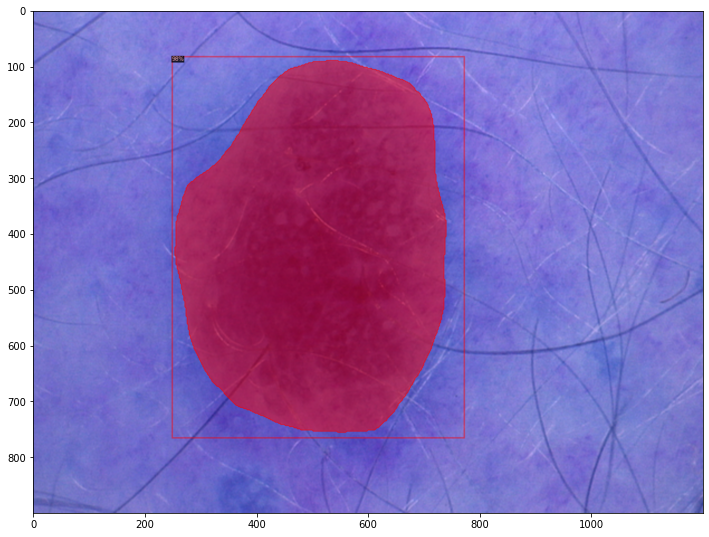

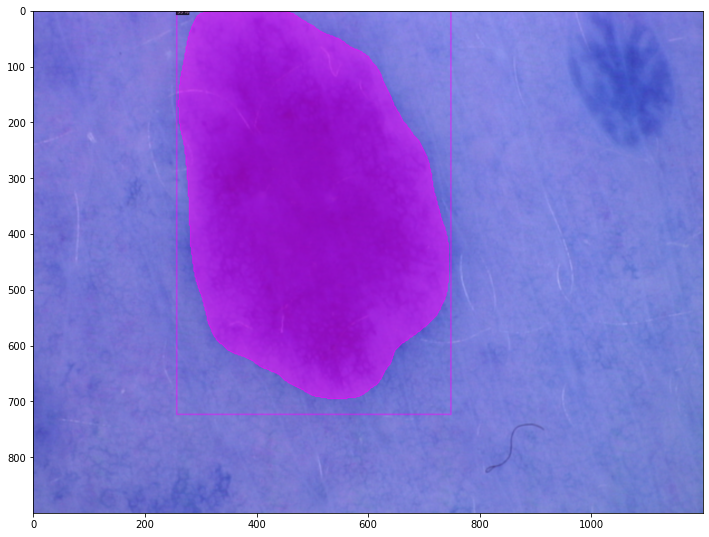

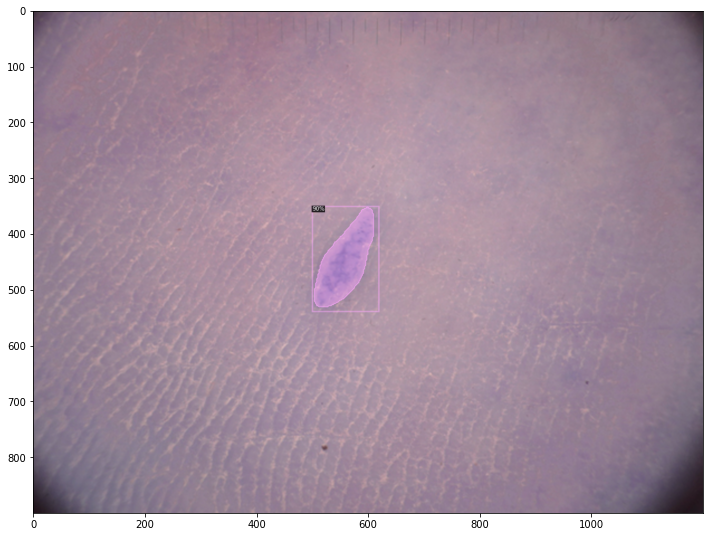

In [ ]:
# Let's perform inferencing on random samples and preview the predictions before proceeding.
if HEADLESS_MODE==False:
    for d in random.sample(dataset_dicts, 3):    
            im = cv2.imread(d["file_name"])
            outputs = predictor(im)
            categories = outputs["instances"].to("cpu").pred_classes.numpy()
            predicted_boxes = outputs["instances"].to("cpu").pred_boxes
            
            if MODE=='segmentation-rle':
                pred_masks = outputs["instances"].to("cpu").pred_masks.numpy()

            if len(categories) != 0:
                for i in range(len(categories)):
                    classname = thing_classes[categories[i]]
                    for item in ontology:
                        if classname==item['name']:
                            schema_id = item['featureSchemaId']

            v = Visualizer(im[:, :, ::-1],
                        metadata=metadata, 
                        scale=2, 
            )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            ## For paperspace cloud notebooks. Cloud notebooks do not support cv2.imshow.
            plt.rcParams['figure.figsize'] = (12, 24)
            plt.imshow(v.get_image()[:, :, ::-1])
            plt.show()

# Delete existing model assisted labels from the Labelbox project

In [ ]:
#Delete all existing bulk import requests from the Project. This will delete predictions from queued datarows.

all_import_requests = get_current_import_requests()

for task in all_import_requests:
    response = delete_import_request(task['id'])
    print(response)

{'deleteBulkImportRequest': {'id': 'c0acc67d-cae1-449f-aa63-a539df0878f7', 'name': 'pre-labeling-09-12-2020-09-18-49'}}
{'deleteBulkImportRequest': {'id': 'be58c8d4-3a53-474c-8f93-52e6756328da', 'name': 'pre-labeling-09-11-2020-09-10-18'}}
{'deleteBulkImportRequest': {'id': '36a0b77d-ed6b-4e93-84fd-3db71b011ed2', 'name': 'pre-labeling-09-10-2020-08-33-28'}}


# Compute unlabeled datarows

In [ ]:
## Get datarows that needs to be pre-labeled. We are performing a subtraction (all datarows in project - labeled datarows)
datarow_ids_with_labels = []

for label in labels:
    datarow_ids_with_labels.append(label['DataRow ID'])
    
all_datarow_ids = []
all_datarows = []

for dataset_id in DATASETS:
    dataset = client.get_dataset(dataset_id)
    for data_row in dataset.data_rows():
        all_datarow_ids.append(data_row.uid)
        all_datarows.append(data_row)

datarow_ids_queued = diff_lists(all_datarow_ids, datarow_ids_with_labels)

print('Number of datarows to be pre-labeled: ', len(datarow_ids_queued))


Number of datarows to be pre-labeled:  7465


# Download unlabeled data for inferencing

In [ ]:
## Download queued datarows that needs to be pre-labeled

data_row_queued = []
data_row_queued_urls = []

for datarow in all_datarows:
    for datarow_id in datarow_ids_queued:
        if datarow.uid == datarow_id:
            data_row_queued.append(datarow)
            extension = os.path.splitext(datarow.external_id)[1]
            filename = datarow.uid + extension
            data_row_queued_urls.append((DATA_LOCATION+'inference/' + filename, datarow.row_data))

print('Downloading queued data for inferencing...\n')
filepath_inference = ThreadPool(NUM_CPU_THREADS).imap_unordered(download_files, data_row_queued_urls)
print('Success...\n')


Success...



# Perform inferencing

In [ ]:
## Inferencing on queued datarows and create labelbox annotation import file (https://labelbox.com/docs/automation/model-assisted-labeling)

predictions = []
counter = 1

print("Inferencing...\n")
time.sleep(1)
bar = progressbar.ProgressBar(maxval=len(data_row_queued), \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
    
for datarow in data_row_queued:
    extension = os.path.splitext(datarow.external_id)[1]
    filename = DATA_LOCATION+'inference/' + datarow.uid + extension
    im = cv2.imread(filename)
    
    ##Predict using FB Detectron2 predictor
    outputs = predictor(im)
    
    categories = outputs["instances"].to("cpu").pred_classes.numpy()
    predicted_boxes = outputs["instances"].to("cpu").pred_boxes

    if len(categories) != 0:
        for i in range(len(categories)):
            
            classname = thing_classes[categories[i]]
            
            for item in ontology:
                if classname==item['name']:
                    schema_id = item['featureSchemaId']
            
            if MODE=='segmentation-rle':
                pred_mask = outputs["instances"][i].to("cpu").pred_masks.numpy()
                cloud_mask = mask_to_cloud(im,pred_mask, datarow.uid)
                mask = {'instanceURI': cloud_mask, "colorRGB": [255,255,255]}
                predictions.append({"uuid": str(uuid4()),'schemaId': schema_id, 'mask': mask, 'dataRow': { 'id': datarow.uid }})
                
            if MODE=='object-detection':
                bbox = predicted_boxes[i].tensor.numpy()[0]
                bbox_dimensions = {'left': int(bbox[0]), 'top': int(bbox[1]), 'width': int(bbox[2]-bbox[0]), 'height': int(bbox[3]-bbox[1])}
                predictions.append({"uuid": str(uuid4()),'schemaId': schema_id, 'bbox': bbox_dimensions, 'dataRow': { 'id': datarow.uid }})
            
    # print('\predicted '+ str(counter) + ' of ' + str(len(data_row_queued)))
    bar.update(counter)
    counter = counter + 1
          
bar.finish()
time.sleep(1)
print('Total annotations predicted: ', len(predictions))

Inferencing...



Total annotations predicted:  8815


# Upload model predictions to Labelbox

In [ ]:
##Upload predicted annotations to Labelbox project
now = datetime.now() # current date and time
job_name = 'pre-labeling-' + str(now.strftime("%m-%d-%Y-%H-%M-%S"))

upload_job = project.upload_annotations( 
    name=job_name, 
    annotations=predictions)

print(upload_job)

upload_job.wait_until_done()
assert ( 
    upload_job.state == BulkImportRequestState.FINISHED or
    upload_job.state == BulkImportRequestState.FAILED
)

print(upload_job.state)
print("--- Finished in %s seconds ---" % (time.time() - start_time))


<BulkImportRequest {'created_at': datetime.datetime(2020, 9, 12, 11, 19, 4, 698000, tzinfo=datetime.timezone.utc), 'error_file_url': None, 'input_file_url': 'https://storage.googleapis.com/labelbox-predictions-import-prod/uploaded_predictions/cjhfn5y6s0pk507024nz1ocys/9bed74e3-fa86-614e-7caa-d190b00a406d-ck7wos1ri5o9f0a00jb1oyqgc__pre-labeling-09-12-2020-11-19-02.ndjson?GoogleAccessId=api-prod%40labelbox-193903.iam.gserviceaccount.com&Expires=1603509545&Signature=b6SXOa8vW%2F7fSEzm6CuOeS2u3G%2BPqpf2%2BaRiwKRiFMVggDZXIrA6UwrONZXTZCX7dc8%2BqwE7v0CRFCJvVY4F5lNkBzKWbI3HMAQY6YQAT8%2Ffa78bDWFpbwFDf0wN0p22%2BMYY3RtbcQrSlH5zmPOBrAMHLXgX8sDo3Yg0UxdOyJer9qybqBCF98sNvYPlrb0kNlspf3K%2FYt0A9hR9CMOKmm6jfshB29EGW5HBtJ0iWPAlHl01N%2Bl5o1QuAmeWHCfLzfNkgD0tdlBANYfL1lJOgvMgbXt2tdOeuWHE8ID6bxBNwaVDBS9WgQUsapE4wphMUEoUDEGDC0aUuXS4P7WDSA%3D%3D', 'name': 'pre-labeling-09-12-2020-11-19-02', 'state': <BulkImportRequestState.RUNNING: 'RUNNING'>, 'status_file_url': None, 'uid': '906cb674-c848-4c56-b303-f15cd87e94